In [18]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [19]:
# load data
df_X = pd.read_csv('../data/X.csv', index_col=0)
df_y = pd.read_csv('../data/y.csv', index_col=0)

y = df_y.values.ravel()  # 0 is HER2+, 1 is HR+, 2 is Triple Negative
category_labels = ['HER2+', 'HR+', 'Triple Neg']

In [20]:
def plot_confusion_matrix(y_test, y_pred, categories):
    """
    Plots a confusion matrix using seaborn to compare the ground truth labels
    and the model's predictions.

    Parameters:
    - y_test (array-like): True labels.
    - y_pred (array-like): Predictions from the model.
    - categories (list): List of category names for labeling the axes.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap from the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [21]:
def nested_cv_logreg(X_train, X_test, y_train, y_test, categories):
    # define the model
    log_reg = LogisticRegression(solver='liblinear', multi_class='ovr')

    # define the grid of hyperparameters
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'penalty': ['l1', 'l2'],
                  'max_iter': [100, 200, 300, 400, 500]}

    # configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=12345)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=12345)

    # search
    grid_search = GridSearchCV(log_reg, param_grid, cv=inner_cv)
    cross_val_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)

    grid_search.fit(X_train, y_train)

    print("Mean cross-validation score:", np.mean(cross_val_scores))
    print("Best hyperparameters:", grid_search.best_params_)

    # evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # classification report
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, categories)

    return best_model

In [22]:
def nested_cv_knn(X_train, X_test, y_train, y_test, categories):
    # define the model
    knn = KNeighborsClassifier()

    # define the grid of hyperparameters
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11],
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}

    # configure the nested cross-validation procedure
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=12345)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=12345)

    # search
    grid_search = GridSearchCV(knn, param_grid, cv=inner_cv)
    cross_val_scores = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)

    grid_search.fit(X_train, y_train)

    print("Mean cross-validation score:", np.mean(cross_val_scores))
    print("Best hyperparameters:", grid_search.best_params_)

    # evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # classification report
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, categories)

    return best_model

In [23]:
def roc_plot(X_train, X_test, y_train, y_test, best_model):
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(best_model)
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)

    plt.figure(figzize=(10, 6))
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{category_labels[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

# List 2

In [24]:
# keep selected columns
list_2 = [1902, 1956, 1973, 2026, 2058, 2183, 2184, 2207, 2211, 2213, 2547, 2593, 1672, 118, 192, 695, 772, 791, 854, 1061, 1091, 1559, 1643, 1656, 1678, 1900, 2017, 2021, 2024, 2210, 2218, 2750, 2776, 2791, 2817, 2825]
new_df_X = df_X.iloc[:, list_2]

X = new_df_X.to_numpy()

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

## Logistic regression

Mean cross-validation score: 0.9285714285714286
Best hyperparameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.88      0.93         8
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



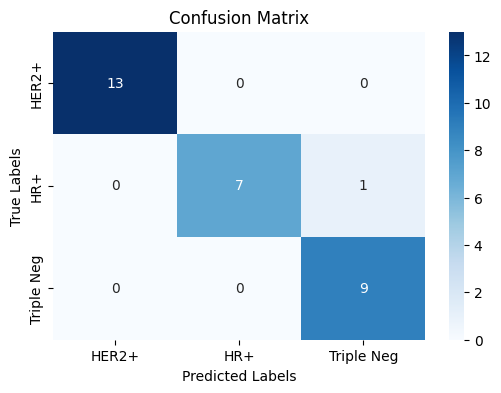

LogisticRegression(C=1, multi_class='ovr', solver='liblinear')

In [25]:
nested_cv_logreg(X_train, X_test, y_train, y_test, category_labels)

Mean cross-validation score: 0.9285714285714286
Best hyperparameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.88      0.93         8
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



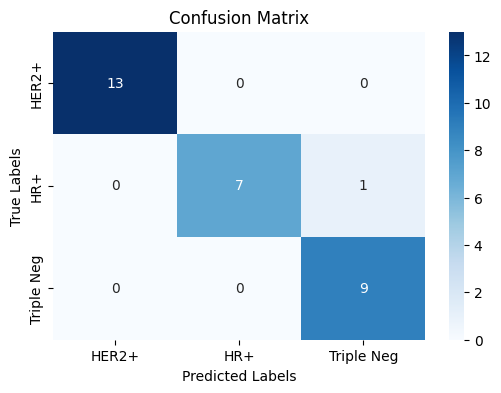

NotFittedError: This OneVsRestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [26]:
roc_plot(X_train, X_test, y_train, y_test, nested_cv_logreg(X_train, X_test, y_train, y_test, category_labels))

## kNN

Mean cross-validation score: 0.7714285714285714
Best hyperparameters: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       0.50      1.00      0.67         8
           2       0.83      0.56      0.67         9

    accuracy                           0.70        30
   macro avg       0.78      0.72      0.70        30
weighted avg       0.82      0.70      0.71        30



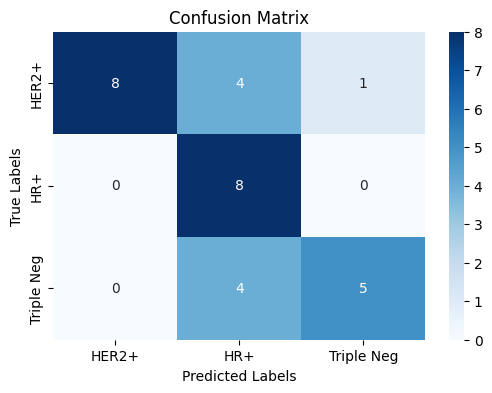

In [8]:
nested_cv_knn(X_train, X_test, y_train, y_test, category_labels)

# List 3

In [9]:
# keep selected columns
list_3 = [2026, 2184, 2213, 791, 1656, 1678, 1900, 2750]
new_df_X = df_X.iloc[:, list_3]

X = new_df_X.to_numpy()

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

## Logistic regression

Mean cross-validation score: 0.9
Best hyperparameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.67      0.75      0.71         8
           2       0.86      0.67      0.75         9

    accuracy                           0.83        30
   macro avg       0.82      0.81      0.81        30
weighted avg       0.84      0.83      0.83        30



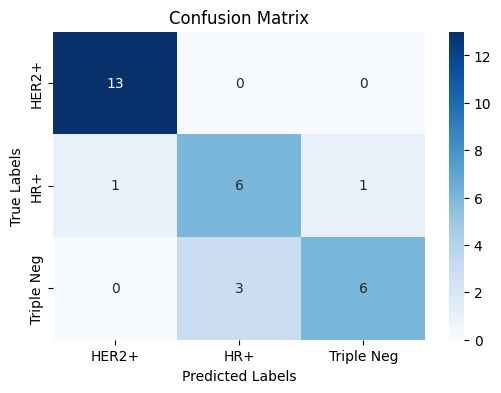

In [10]:
nested_cv_logreg(X_train, X_test, y_train, y_test, category_labels)

## kNN

Mean cross-validation score: 0.9
Best hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.58      0.88      0.70         8
           2       0.80      0.44      0.57         9

    accuracy                           0.80        30
   macro avg       0.79      0.77      0.76        30
weighted avg       0.83      0.80      0.79        30



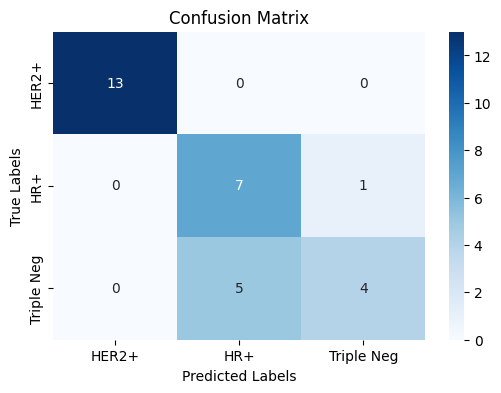

In [11]:
nested_cv_knn(X_train, X_test, y_train, y_test, category_labels)

# List 4

In [12]:
# keep selected columns
list_4 = [2026, 2184, 2213]
new_df_X = df_X.iloc[:, list_4]

X = new_df_X.to_numpy()

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

## Logistic regression

Mean cross-validation score: 0.7142857142857143
Best hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.62      1.00      0.76         8
           2       1.00      0.44      0.62         9

    accuracy                           0.83        30
   macro avg       0.87      0.81      0.79        30
weighted avg       0.90      0.83      0.82        30



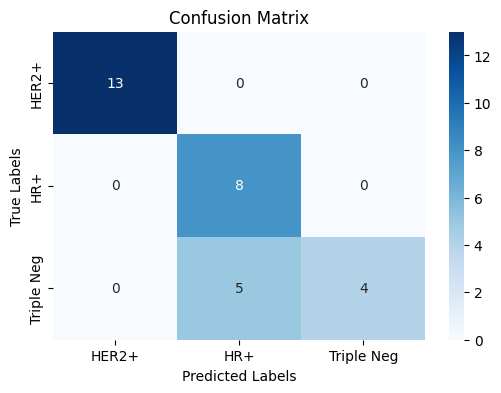

In [13]:
nested_cv_logreg(X_train, X_test, y_train, y_test, category_labels)

## kNN

Mean cross-validation score: 0.6571428571428573
Best hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.60      0.75      0.67         8
           2       0.75      0.67      0.71         9

    accuracy                           0.80        30
   macro avg       0.78      0.78      0.78        30
weighted avg       0.82      0.80      0.81        30



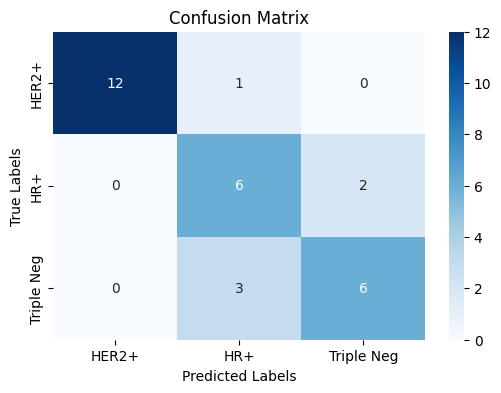

In [14]:
nested_cv_knn(X_train, X_test, y_train, y_test, category_labels)

# List 5

In [15]:
# keep selected columns
list_5 = [2184]
new_df_X = df_X.iloc[:, list_5]

X = new_df_X.to_numpy()

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

## Logistic regression

Mean cross-validation score: 0.5857142857142856
Best hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.47      1.00      0.64         8
           2       0.00      0.00      0.00         9

    accuracy                           0.70        30
   macro avg       0.49      0.67      0.55        30
weighted avg       0.56      0.70      0.60        30



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

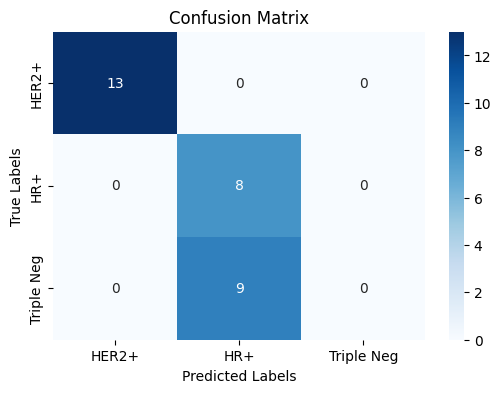

In [16]:
nested_cv_logreg(X_train, X_test, y_train, y_test, category_labels)

## kNN

Mean cross-validation score: 0.6142857142857142
Best hyperparameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.50      0.25      0.33         8
           2       0.54      0.78      0.64         9

    accuracy                           0.73        30
   macro avg       0.68      0.68      0.66        30
weighted avg       0.73      0.73      0.71        30



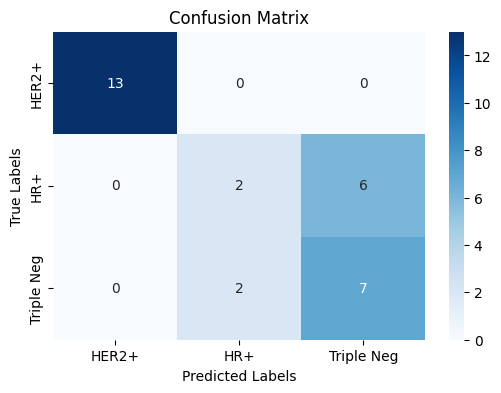

In [17]:
nested_cv_knn(X_train, X_test, y_train, y_test, category_labels)